# Fonetica acustica: lingue tonali - non tonali a confronto

**di Fiocchi Gabriele** 
*(uso di ChatGPT per acquisire conoscenze sulla fonetica e su metodi di estrazione di frequenze fondamentali; uso della documentazione di Praat-parselmouth per l'implementazione di alcune funzioni)*

## Obiettivo
Questo progetto si propone di confrontare due tipologie di lingua — una tonale, come il cinese mandarino, e una non tonale, come l'inglese — dal punto di vista acustico, con particolare attenzione alla variazione della frequenza fondamentale (ovvero il valore della frequenza di vibrazione della glottide) e al suo ruolo nella comunicazione.

Questa frequenza infatti, variando nel tempo, è responsabile del cambiamento di tono in una parola.

Nelle lingue **tonali**, come il mandarino, il tono è essenziale per distinguere il significato delle parole: la stessa sequenza di suoni può assumere significati completamente diversi a seconda della tonalità con cui è pronunciata. Ad esempio, la parola "ma" può significare "madre", "cavallo", "sgridare" o "canapa".

Al contrario, nelle lingue **non tonali**, come l'inglese, l'intonazione non modifica il significato lessicale delle parole, ma gioca un ruolo importante nell'espressione di emozioni, intenzioni e struttura grammaticale. Ad esempio, l'intonazione di una frase che include la parola "cat" può differire a seconda che sia una **dichiarazione** ("*There's a cat.*") o una **domanda** ("*Is there a cat?*").

Questo progetto mira a:

- Analizzare e visualizzare i contorni tonali di parole specifiche in cinese mandarino, confrontandoli con l'intonazione di parole inglesi in contesti diversi.
- Evidenziare le differenze principali tra lingue tonali e non tonali, sia a livello acustico che funzionale.
- Utilizzare tecniche avanzate di elaborazione audio per estrarre e normalizzare pitch, rendendo i risultati comparabili nonostante le differenze intrinseche tra voci e registrazioni.


In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, Image, display
import numpy as np
import parselmouth


# Paths to audio files
ma_files = {
    "High-Level (Madre)": "AUDIO/MA/ma1.wav",
    "Rising (Canapa)": "AUDIO/MA/ma2.wav",
    "Low (Cavallo)": "AUDIO/MA/ma3.wav",
    "Falling (Sgridare)": "AUDIO/MA/ma4.wav",
}

ba_files = {
    "High-Level (Otto)": "AUDIO/BA/ba1.wav",
    "Rising (Estrarre)": "AUDIO/BA/ba2.wav",
    "Low (Obbiettivo)": "AUDIO/BA/ba3.wav",
    "Falling (Padre)": "AUDIO/BA/ba4.wav",
}

cat_clips_female = {
    "Cat question female (clip)":"AUDIO/WAV/cat_question.wav",
    "Cat sentence female (clip)":"AUDIO/WAV/cat_sentence.wav"
}

cat_full_female = {
    "Cat question female (full)":"AUDIO/WAV/cat_full_question.wav",
    "Cat sentence female (full)":"AUDIO/WAV/cat_full_sentence.wav"
}

cat_clips_male = {
    "Cat question male (clip)":"AUDIO/WAV/cat_question2.wav",
    "Cat sentence male (clip)":"AUDIO/WAV/cat_sentence2.wav"
}

cat_full_male = {
    "Cat question male (full)":"AUDIO/WAV/cat_full_question2.wav",
    "Cat sentence male (full)":"AUDIO/WAV/cat_full_sentence2.wav"
}

cat_vocals = {
    "Female question":"AUDIO/WAV/cat_question_vocal.wav",
    "Female sentence":"AUDIO/WAV/cat_sentence_vocal.wav",
    "Male question":"AUDIO/WAV/cat_question_vocal2.wav",
    "Male sentence":"AUDIO/WAV/cat_sentence_vocal2.wav"
}

# Dictionaries to store data and sample rates for each tone
data = {}
sample_rates = {}

## Metodi
Per analizzare il parlato presente negli audio ho utilizzato diversi metodi:

### Caricamento e Visualizzazione dei File Audio
Usando la libreria librosa ho convertito i file audio in array di numeri; questo processo si basa sul campionamento, che consiste nel prendere valori discreti a intervalli regolari, definiti dal sample rate (impostando questo a None, si mantiene il sample rate originale);

In [2]:
def load_audio(audio_files):
    for audio, file in audio_files.items():
        y, sr = librosa.load(file, sr=None)
        data[audio] = y
        sample_rates[audio] = sr

def display_audio(audio_files):
    for audio, file in audio_files.items():
        print(f"{audio}:")
        display(Audio(data=file, rate=sample_rates[audio]))

### Estrazione frequenze fondamentali
Tramite la libreria Praat Parselmouth ho estratto le frequenze fondamentali dal parlato e ho rimpiazzato le frequenze sotto i 90 Hz con NaN; questo passaggio è necessario per eliminare dal grafico il possibile rumore o le zone di silenzio. </br>
Il risultato è simile a quello ottenibile tramite una trasformata di Fourier con filtro passa-alto, ma invece di eliminare il rumore, questo non viene visualizzato nel grafico.

In [3]:
# Function to extract pitch (F0)
def extract_pitch(audio_file):
    #Load the audio
    snd = parselmouth.Sound(audio_file)
    # Extract the pitch (F0)
    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']  # F0 values
    # Replace low-pitch regions (<90 Hz) with nan for better plotting
    pitch_values[pitch_values < 90] = np.nan
    time_values = pitch.xs()  # Time values
    
    return time_values, pitch_values

### Normalizzazione del pitch e del tempo
Siccome non mi è stato possibile trovare audio provenienti dallo stesso parlante in inglese, in tali casi ho dovuto normalizzare i valori di pitch in un intervallo tra 0 ed 1, in modo da eliminare differenze dovute a fattori individuali, come ad esempio il sesso del parlante, infatti voci maschili tendono ad avere frequenze più gravi.
Anche il tempo va normalizzato in quanto anche questo è soggetto a fattori individuali come i differenti ritmi del parlato.

In [4]:
def normalize_pitch(time, f0):
    #Normalize pitch between 0 and 1
    f0 = (f0 - np.min(f0)) / (np.max(f0) - np.min(f0))
    #Normalize time
    time = np.linspace(0, 1, len(f0))
    return time, f0

### Visualizzazione dei contorni del pitch
Infine creo un grafico che mostra i contorni delle frequenze fondamentali ponendo sull'asse delle X il tempo e su quello delle Y le frequenze.

In [5]:
def pitch_contours(audio_files, language, word, normalize):
    # Plot pitch contours for each tone
    plt.figure(figsize=(10, 6))
    for tone, file in audio_files.items():
        time, f0 = extract_pitch(file)
        #Normalize pitch when different speakers
        if(normalize):
            time, f0=normalize_pitch(time, f0)
        plt.plot(time, f0, label=tone)
    plt.title(f"Pitch Contours of {language} Tones (Word: '{word}')")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.show()

## Esperimenti

### Analisi del cinese mandarino
Ho analizzato i quattro toni della parola "ma" e della parola "ba", confrontando le frequenze fondamentali di ciascuno.
Nei grafici, i contorni tonali sono facilmente distinguibili:
\begin{itemize}
    \item Il tono alto è caratterizzato da una curva abbastanza piatta e stabile.
    \item Il tono crescente mostra una pendenza positiva.
    \item Il tono basso ha valori di frequenze tendenzialmente bassi.
    \item Il tono discendente ha una pendenza negativa.
\end{itemize}

Questo conferma che il pitch è un elemento chiave per il significato lessicale nelle lingue tonali.

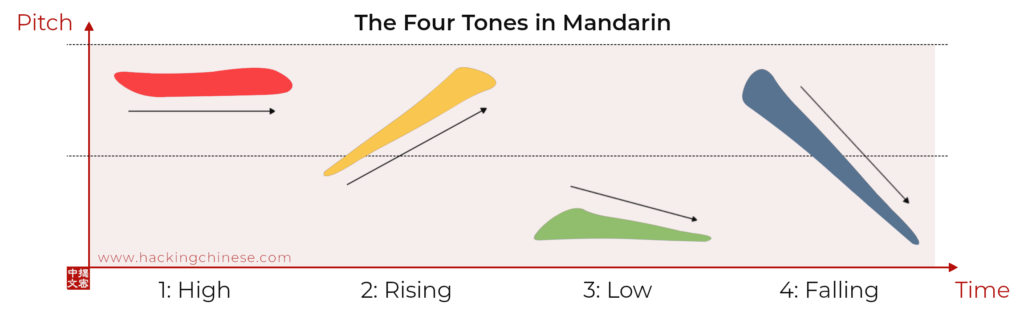

In [11]:
Image(filename="AUDIO/all-four-tones-chart.png")

High-Level (Otto):


Rising (Estrarre):


Low (Obbiettivo):


Falling (Padre):


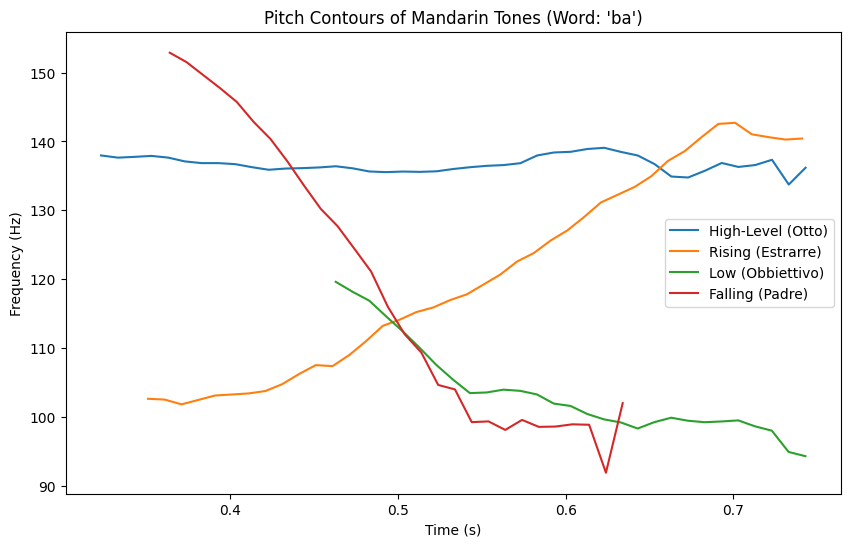

In [7]:
load_audio(ba_files)
display_audio(ba_files)
pitch_contours(ba_files, "Mandarin", "ba", False)

High-Level (Madre):


Rising (Canapa):


Low (Cavallo):


Falling (Sgridare):


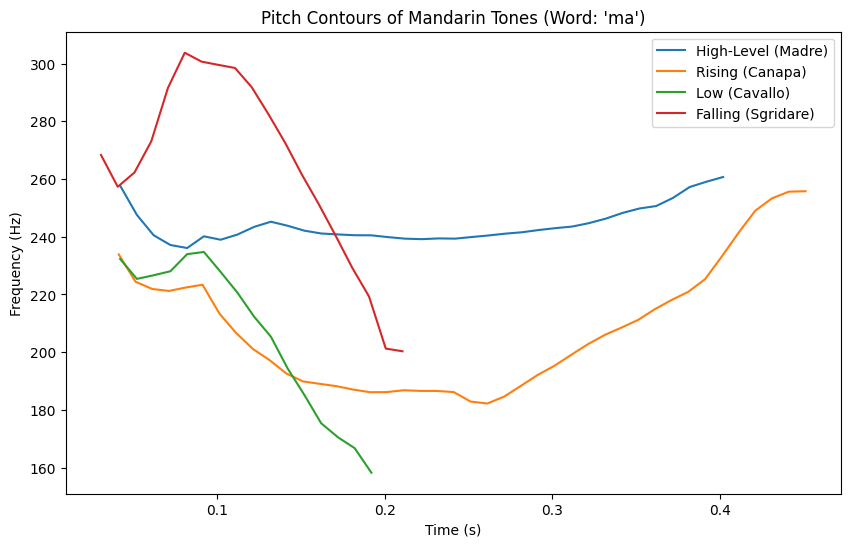

In [8]:
load_audio(ma_files)
display_audio(ma_files)
pitch_contours(ma_files, "Mandarin", "ma", False)

### Analisi dell'inglese
Ho confrontato le frequenze fondamentali nella vocale della parola "cat" in contesti diversi (domanda e affermazione) per due parlanti: uno maschile ed uno femminile:
\begin{itemize}
    \item La domanda mostra un'intonazione ascendente.
    \item L'affermazione ha un'intonazione discendente
\end{itemize}
Questo evidenzia che l'intonazione nelle lingue non tonali esprime intenzioni grammaticali.

Cat question female (full):


Cat sentence female (full):


Cat question male (full):


Cat sentence male (full):


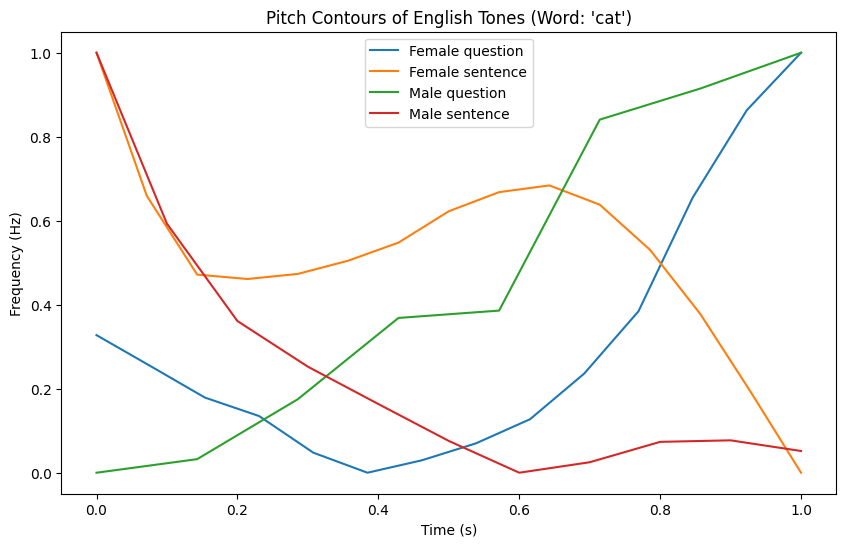

In [9]:
load_audio(cat_vocals)
load_audio(cat_full_male)
load_audio(cat_full_female)
display_audio(cat_full_female)
display_audio(cat_full_male)
pitch_contours(cat_vocals, "English", "cat", True)

### Risultato finale
Analizzando le curve del pitch, si osserva una differenza fondamentale tra le due lingue:
\begin{itemize}
    \item Nel cinese mandarino, il tono è una proprietà lessicale (cambia il significato della parola).
    \item Nell'inglese, l'intonazione è una proprietà prosodica (cambia il significato della frase o aggiunge sfumature emotive).
\end {itemize}

## Approfondimenti
Nel approfondimento voglio trattare due argomenti:

### Iniziale approccio al progetto
Il mio progetto si distingue per l’analisi di segnali del parlato, ovvero segnali con una gamma di frequenze limitata a quella prodotta dalle corde vocali durante il parlato umano. Questi segnali si collocano in un intervallo di frequenze più ristretto rispetto a quello di una voce che canta, o addirittura a quello prodotto da strumenti musicali.
</br></br>
All’inizio del lavoro, la mia idea era di analizzare testi lunghi in diverse lingue per identificare eventuali differenze nei segnali del parlato. Tuttavia, è emerso un limite: le frequenze prodotte dalla voce umana sono sostanzialmente le stesse indipendentemente dalla lingua parlata. Questa uniformità ha portato a risultati simili tra lingue diverse, vanificando l’obiettivo di evidenziare caratteristiche distintive.
</br></br>
Per superare questa difficoltà, ho deciso di riformulare l’ipotesi iniziale, concentrandomi su unità più fondamentali: i singoli fonemi che costituiscono le parole. I fonemi, infatti, non solo differiscono per caratteristiche acustiche, ma possono anche assumere ruoli grammaticali distinti a seconda del contesto linguistico. Questo nuovo approccio mi ha permesso di analizzare in modo più dettagliato le variazioni nei segnali vocali, esplorando la relazione tra le caratteristiche acustiche dei fonemi e le loro funzioni grammaticali.

### Spettrogrammi
Ho tentato di evidenziare le frequenze prodotte dalle vocali attraverso l'uso di spettrogrammi; le vocali sono foni prodotti con un canale fonatorio libero, che non presenta chiusure né restringimenti. La loro produzione è quindi caratterizzata da una gran quantità di flusso d’aria espiratoria per tutta la loro durata e ciò, in termini acustici, corrisponde ad un segnale molto intenso; gli spettrogrammi dunque sono un ottimo strumento per visualizzare ove si trovano le vocali in quanto il tracciato sarà particolarmente annerito in corrispondenza di queste. Questo risultato si nota maggiormente nelle frasi prodotte dagli individui maschili, non tanto per questioni relative al sesso del parlante ma poiché sono povere di vocali se non nella parola "cat", ovvero quella presa in analisi. 

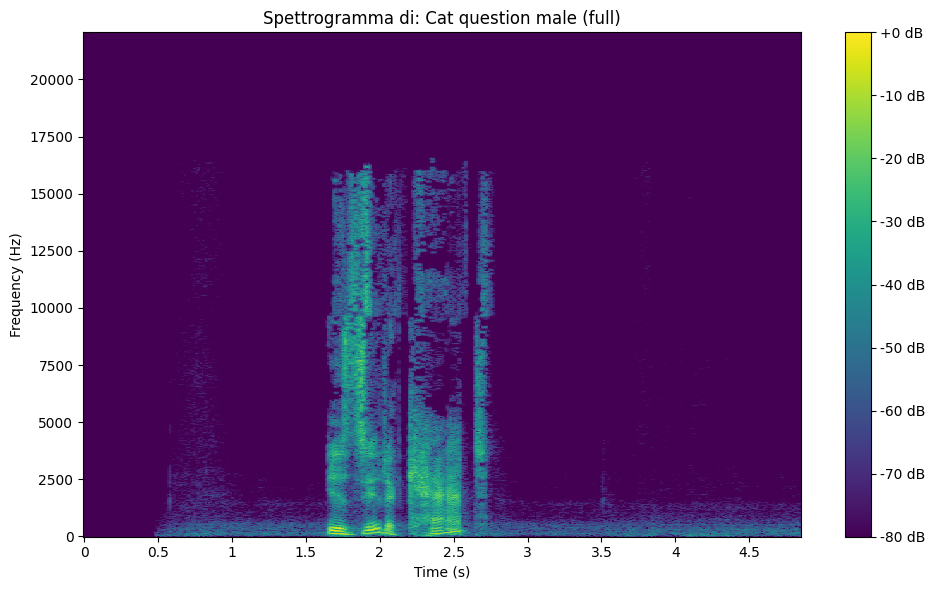

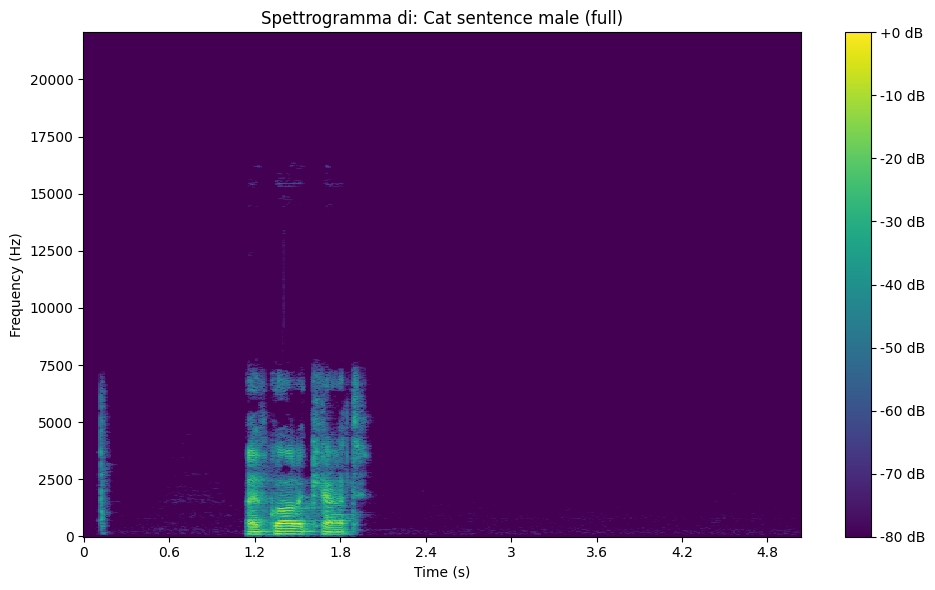

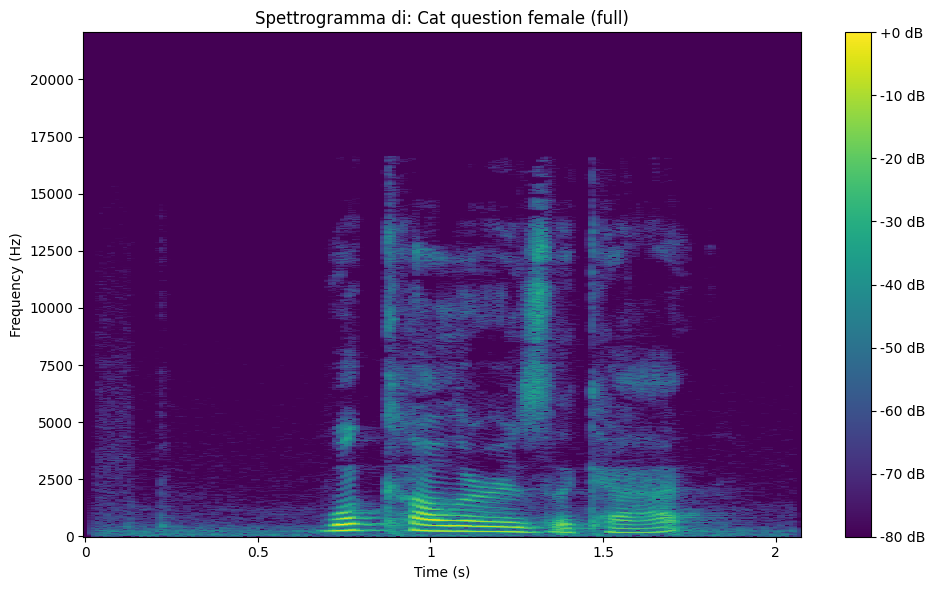

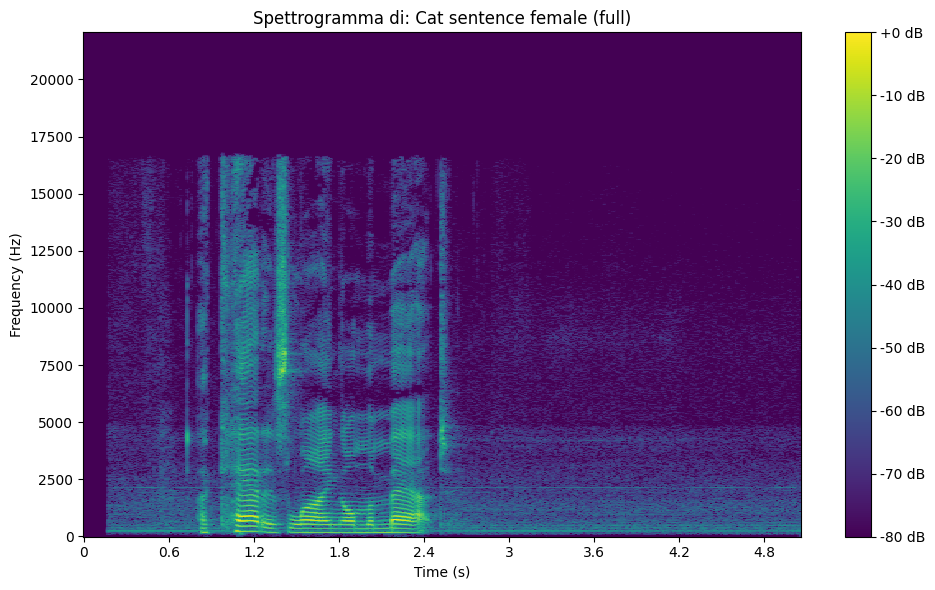

In [10]:
def plot_spectrogram(audio):
    S = librosa.stft(data[audio])
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_db, sr=sample_rates[audio], x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spettrogramma di: {audio}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()
    
for audio, file in cat_full_male.items():
    plot_spectrogram(audio)
    
for audio, file in cat_full_female.items():
    plot_spectrogram(audio)